In [6]:
# ============================================
# 🤖 INTELLIGENT FOREX TRADING BOT
# Complete Google Colab Implementation
# ============================================

# ============================================
# 📌 STEP 1: Setup & Install Dependencies
# ============================================

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import ta
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries installed and imported successfully!")

# ============================================
# 📌 STEP 2: Forex Data Collection
# ============================================

# Major Forex Pairs - Yahoo Finance format
FOREX_PAIRS = {
    "EURUSD=X": "EUR/USD",
    "GBPUSD=X": "GBP/USD",
    "USDJPY=X": "USD/JPY",
    "AUDUSD=X": "AUD/USD",
    "USDCAD=X": "USD/CAD",
    "USDCHF=X": "USD/CHF",
    "NZDUSD=X": "NZD/USD",
    "EURGBP=X": "EUR/GBP",
    "EURJPY=X": "EUR/JPY",
    "GBPJPY=X": "GBP/JPY",
    "AUDJPY=X": "AUD/JPY",
    "CHFJPY=X": "CHF/JPY",
    "EURAUD=X": "EUR/AUD",
    "EURCAD=X": "EUR/CAD"
}

def download_forex_data(pairs, period="5y", interval="1h"):
    """Download forex data for all pairs"""
    data = {}
    print(f"📥 Downloading {len(pairs)} forex pairs...")

    for symbol, name in pairs.items():
        try:
            df = yf.download(symbol, period=period, interval=interval)
            if not df.empty:
                df.dropna(inplace=True)
                data[name] = df
                print(f"✅ {name}: {len(df)} data points")
            else:
                print(f"❌ {name}: No data available")
        except Exception as e:
            print(f"❌ {name}: Error - {e}")

    return data

# Download all forex data
forex_data = download_forex_data(FOREX_PAIRS)
print(f"\n📊 Successfully downloaded {len(forex_data)} forex pairs")

# ============================================
# 📌 STEP 3: Advanced Feature Engineering
# ============================================

def calculate_technical_indicators(df):
    """Calculate comprehensive technical indicators"""
    df = df.copy()

    # Basic price features
    df['returns'] = df['Close'].pct_change()
    df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['high_low_pct'] = (df['High'] - df['Low']) / df['Close']
    df['open_close_pct'] = (df['Close'] - df['Open']) / df['Open']

    # Moving averages
    df['sma_5'] = df['Close'].rolling(window=5).mean()
    df['sma_20'] = df['Close'].rolling(window=20).mean()
    df['sma_50'] = df['Close'].rolling(window=50).mean()
    df['ema_12'] = df['Close'].ewm(span=12).mean()
    df['ema_26'] = df['Close'].ewm(span=26).mean()

    # Technical indicators
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
    df['macd'] = ta.trend.MACD(df['Close']).macd()
    df['macd_signal'] = ta.trend.MACD(df['Close']).macd_signal()
    df['macd_diff'] = df['macd'] - df['macd_signal']

    # Bollinger Bands
    bb = ta.volatility.BollingerBands(df['Close'])
    df['bb_high'] = bb.bollinger_hband()
    df['bb_low'] = bb.bollinger_lband()
    df['bb_mid'] = bb.bollinger_mavg()
    df['bb_width'] = (df['bb_high'] - df['bb_low']) / df['bb_mid']
    df['bb_position'] = (df['Close'] - df['bb_low']) / (df['bb_high'] - df['bb_low'])

    # Volatility measures
    df['atr'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range()
    df['volatility_5'] = df['returns'].rolling(window=5).std()
    df['volatility_20'] = df['returns'].rolling(window=20).std()

    # Volume indicators (if available)
    if 'Volume' in df.columns and df['Volume'].sum() > 0:
        df['volume_sma'] = df['Volume'].rolling(window=20).mean()
        df['volume_ratio'] = df['Volume'] / df['volume_sma']

    # Momentum indicators
    df['momentum_5'] = df['Close'] / df['Close'].shift(5) - 1
    df['momentum_10'] = df['Close'] / df['Close'].shift(10) - 1
    df['roc'] = ta.momentum.ROCIndicator(df['Close']).roc()

    # Support/Resistance levels
    df['resistance'] = df['High'].rolling(window=20).max()
    df['support'] = df['Low'].rolling(window=20).min()
    df['support_resistance_ratio'] = (df['Close'] - df['support']) / (df['resistance'] - df['support'])

    return df

# Apply feature engineering to all forex pairs
print("🔧 Applying feature engineering...")
processed_data = {}
for name, df in forex_data.items():
    processed_data[name] = calculate_technical_indicators(df)
    print(f"✅ {name}: {len(processed_data[name].columns)} features created")

# ============================================
# 📌 STEP 4: Create Universal Training Dataset
# ============================================

def create_labels(df, horizon=3, threshold=0.0005):
    """Create trading labels based on future returns"""
    df = df.copy()

    # Forward returns at different horizons
    df['future_return_1'] = df['Close'].shift(-1) / df['Close'] - 1
    df['future_return_3'] = df['Close'].shift(-horizon) / df['Close'] - 1
    df['future_return_5'] = df['Close'].shift(-5) / df['Close'] - 1

    # Binary classification labels
    df['target_binary'] = (df['future_return_3'] > threshold).astype(int)

    # Multi-class labels (Strong Buy, Buy, Hold, Sell, Strong Sell)
    conditions = [
        df['future_return_3'] > 0.002,   # Strong Buy
        df['future_return_3'] > 0.0005,  # Buy
        df['future_return_3'] > -0.0005, # Hold
        df['future_return_3'] > -0.002,  # Sell
    ]
    choices = [2, 1, 0, -1]
    df['target_multiclass'] = np.select(conditions, choices, default=-2)  # Strong Sell

    # Regression target (actual future return)
    df['target_regression'] = df['future_return_3']

    return df

# Create training dataset combining all forex pairs
def create_universal_dataset(processed_data):
    """Combine all forex pairs into one training dataset"""
    all_data = []

    for pair_name, df in processed_data.items():
        df_with_labels = create_labels(df)
        df_with_labels['pair'] = pair_name
        all_data.append(df_with_labels)

    # Combine all data
    universal_df = pd.concat(all_data, ignore_index=True)

    # Encode pair names
    le = LabelEncoder()
    universal_df['pair_encoded'] = le.fit_transform(universal_df['pair'])

    return universal_df, le

print("📊 Creating universal training dataset...")
universal_df, pair_encoder = create_universal_dataset(processed_data)
print(f"✅ Universal dataset created: {len(universal_df)} rows, {len(universal_df.columns)} columns")

# ============================================
# 📌 STEP 5: Prepare Features for ML Model
# ============================================

# Define feature columns (excluding target variables and metadata)
feature_columns = [col for col in universal_df.columns if not col.startswith(('target_', 'future_', 'pair'))
                  and col not in ['Open', 'High', 'Low', 'Close', 'Volume']] + ['pair_encoded']

# Remove rows with NaN values
clean_df = universal_df[feature_columns + ['target_binary', 'target_regression']].dropna()

print(f"📈 Features selected: {len(feature_columns)} features")
print(f"🧹 Clean dataset: {len(clean_df)} rows")

# ============================================
# 📌 STEP 6: Train ML Models
# ============================================

# Prepare training data
X = clean_df[feature_columns]
y_binary = clean_df['target_binary']
y_regression = clean_df['target_regression']

# Split data (time-series aware split)
split_idx = int(len(clean_df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_binary_train, y_binary_test = y_binary.iloc[:split_idx], y_binary.iloc[split_idx:]
y_reg_train, y_reg_test = y_regression.iloc[:split_idx], y_regression.iloc[split_idx:]

print(f"📊 Training set: {len(X_train)} samples")
print(f"📊 Test set: {len(X_test)} samples")

# Train Binary Classification Model (Direction)
print("🤖 Training direction prediction model...")
lgb_params_clf = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

train_data_clf = lgb.Dataset(X_train, label=y_binary_train)
val_data_clf = lgb.Dataset(X_test, label=y_binary_test, reference=train_data_clf)

model_direction = lgb.train(
    lgb_params_clf,
    train_data_clf,
    num_boost_round=200,
    valid_sets=[val_data_clf],
    early_stopping_rounds=50,
    verbose_eval=False
)

# Train Regression Model (Magnitude)
print("🤖 Training magnitude prediction model...")
lgb_params_reg = {
    'objective': 'regression',
    'metric': 'l2',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

train_data_reg = lgb.Dataset(X_train, label=y_reg_train)
val_data_reg = lgb.Dataset(X_test, label=y_reg_test, reference=train_data_reg)

model_magnitude = lgb.train(
    lgb_params_reg,
    train_data_reg,
    num_boost_round=200,
    valid_sets=[val_data_reg],
    early_stopping_rounds=50,
    verbose_eval=False
)

print("✅ Models trained successfully!")

# ============================================
# 📌 STEP 7: Model Evaluation
# ============================================

# Predictions
y_binary_pred = (model_direction.predict(X_test) > 0.5).astype(int)
y_reg_pred = model_magnitude.predict(X_test)

# Direction accuracy
direction_accuracy = accuracy_score(y_binary_test, y_binary_pred)
print(f"🎯 Direction Prediction Accuracy: {direction_accuracy:.4f}")

# Magnitude correlation
magnitude_correlation = np.corrcoef(y_reg_test, y_reg_pred)[0, 1]
print(f"📈 Magnitude Prediction Correlation: {magnitude_correlation:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model_direction.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("\n🔍 Top 10 Most Important Features:")
print(feature_importance.head(10))

# ============================================
# 📌 STEP 8: Trading Strategy Implementation
# ============================================

class ForexTradingBot:
    def __init__(self, model_direction, model_magnitude, feature_columns, pair_encoder):
        self.model_direction = model_direction
        self.model_magnitude = model_magnitude
        self.feature_columns = feature_columns
        self.pair_encoder = pair_encoder
        self.balance = 1000  # Starting balance
        self.positions = {}
        self.trade_history = []

    def calculate_position_size(self, predicted_return, confidence, volatility, max_risk_per_trade=0.02):
        """Calculate position size based on Kelly criterion and risk management"""
        # Kelly fraction (simplified)
        win_prob = confidence
        avg_win = abs(predicted_return) if predicted_return > 0 else 0.001
        avg_loss = abs(predicted_return) if predicted_return < 0 else 0.001

        kelly_fraction = (win_prob * avg_win - (1 - win_prob) * avg_loss) / avg_win
        kelly_fraction = max(0, min(kelly_fraction, 0.25))  # Cap at 25%

        # Adjust for volatility
        vol_adjustment = min(1.0, 0.01 / max(volatility, 0.001))

        # Final position size
        position_fraction = kelly_fraction * vol_adjustment * max_risk_per_trade
        return min(position_fraction, max_risk_per_trade)

    def calculate_leverage(self, confidence, volatility, max_leverage=10):
        """Calculate safe leverage based on confidence and volatility"""
        base_leverage = min(max_leverage, confidence * 10)
        vol_penalty = max(0.1, 1 - volatility * 100)  # Reduce leverage in high volatility
        return max(1, base_leverage * vol_penalty)

    def generate_signal(self, features):
        """Generate trading signal from features"""
        # Get predictions
        direction_prob = self.model_direction.predict(features.values.reshape(1, -1))[0]
        predicted_return = self.model_magnitude.predict(features.values.reshape(1, -1))[0]

        # Calculate confidence and volatility from features
        confidence = abs(direction_prob - 0.5) * 2  # 0 to 1 scale
        volatility = features.get('volatility_20', 0.01)

        # Generate signal
        signal = {
            'direction': 1 if direction_prob > 0.5 else -1,
            'confidence': confidence,
            'predicted_return': predicted_return,
            'volatility': volatility,
            'probability': direction_prob
        }

        return signal

    def execute_trade(self, pair, signal, current_price):
        """Execute trade based on signal"""
        if signal['confidence'] < 0.1:  # Skip low confidence trades
            return None

        # Calculate position size and leverage
        position_size = self.calculate_position_size(
            signal['predicted_return'],
            signal['confidence'],
            signal['volatility']
        )
        leverage = self.calculate_leverage(signal['confidence'], signal['volatility'])

        # Calculate trade amount
        trade_amount = self.balance * position_size * leverage

        trade = {
            'pair': pair,
            'direction': signal['direction'],
            'amount': trade_amount,
            'leverage': leverage,
            'entry_price': current_price,
            'confidence': signal['confidence'],
            'predicted_return': signal['predicted_return'],
            'stop_loss': current_price * (0.99 if signal['direction'] == 1 else 1.01),
            'take_profit': current_price * (1.02 if signal['direction'] == 1 else 0.98)
        }

        self.positions[pair] = trade
        return trade

# ============================================
# 📌 STEP 9: Backtesting Engine
# ============================================

def run_backtest(bot, test_data, pairs_to_trade=['EUR/USD', 'GBP/USD', 'USD/JPY']):
    """Run comprehensive backtest"""
    results = {
        'trades': [],
        'daily_balance': [],
        'pairs_performance': {pair: [] for pair in pairs_to_trade}
    }

    print("🔄 Running backtest...")

    for pair in pairs_to_trade:
        if pair not in processed_data:
            continue

        pair_data = processed_data[pair].dropna()
        pair_encoded = bot.pair_encoder.transform([pair])[0]

        for i in range(100, len(pair_data) - 10):  # Leave room for future returns
            current_row = pair_data.iloc[i]

            # Prepare features
            features = pd.Series({col: current_row[col] for col in bot.feature_columns if col != 'pair_encoded'})
            features['pair_encoded'] = pair_encoded

            # Generate signal
            try:
                signal = bot.generate_signal(features)

                # Execute trade
                trade = bot.execute_trade(pair, signal, current_row['Close'])

                if trade:
                    # Simulate trade outcome
                    future_price = pair_data.iloc[i + 3]['Close']  # 3 periods ahead
                    actual_return = (future_price - trade['entry_price']) / trade['entry_price']

                    if trade['direction'] == -1:
                        actual_return = -actual_return

                    # Calculate P&L
                    pnl = actual_return * trade['amount']
                    bot.balance += pnl

                    trade['exit_price'] = future_price
                    trade['actual_return'] = actual_return
                    trade['pnl'] = pnl
                    trade['new_balance'] = bot.balance

                    results['trades'].append(trade)
                    results['pairs_performance'][pair].append(pnl)

            except Exception as e:
                continue

    results['final_balance'] = bot.balance
    results['total_return'] = (bot.balance - 1000) / 1000
    results['num_trades'] = len(results['trades'])

    return results

# Initialize and run backtest
print("🤖 Initializing trading bot...")
bot = ForexTradingBot(model_direction, model_magnitude, feature_columns, pair_encoder)

backtest_results = run_backtest(bot)

print(f"\n📊 BACKTEST RESULTS")
print(f"{'='*50}")
print(f"Initial Balance: $1,000")
print(f"Final Balance: ${backtest_results['final_balance']:.2f}")
print(f"Total Return: {backtest_results['total_return']:.2%}")
print(f"Number of Trades: {backtest_results['num_trades']}")

if backtest_results['trades']:
    trades_df = pd.DataFrame(backtest_results['trades'])
    winning_trades = trades_df[trades_df['pnl'] > 0]
    win_rate = len(winning_trades) / len(trades_df)
    avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
    avg_loss = trades_df[trades_df['pnl'] < 0]['pnl'].mean() if len(trades_df[trades_df['pnl'] < 0]) > 0 else 0

    print(f"Win Rate: {win_rate:.2%}")
    print(f"Average Win: ${avg_win:.2f}")
    print(f"Average Loss: ${avg_loss:.2f}")

# ============================================
# 📌 STEP 10: Live Trading Interface
# ============================================

class LiveTradingBot(ForexTradingBot):
    def __init__(self, model_direction, model_magnitude, feature_columns, pair_encoder):
        super().__init__(model_direction, model_magnitude, feature_columns, pair_encoder)
        self.is_running = False

    def get_live_data(self, pair, period="1d", interval="1h"):
        """Get live forex data"""
        yahoo_symbol = None
        for symbol, name in FOREX_PAIRS.items():
            if name == pair:
                yahoo_symbol = symbol
                break

        if yahoo_symbol:
            df = yf.download(yahoo_symbol, period=period, interval=interval)
            return calculate_technical_indicators(df)
        return None

    def get_current_signals(self, pairs_to_monitor=['EUR/USD', 'GBP/USD', 'USD/JPY']):
        """Get current trading signals for specified pairs"""
        signals = {}

        for pair in pairs_to_monitor:
            try:
                # Get latest data
                live_data = self.get_live_data(pair)
                if live_data is not None and len(live_data) > 0:
                    latest_row = live_data.iloc[-1]
                    pair_encoded = self.pair_encoder.transform([pair])[0]

                    # Prepare features
                    features = pd.Series({col: latest_row[col] for col in self.feature_columns if col != 'pair_encoded'})
                    features['pair_encoded'] = pair_encoded

                    # Generate signal
                    signal = self.generate_signal(features)
                    signal['current_price'] = latest_row['Close']
                    signal['pair'] = pair

                    signals[pair] = signal

            except Exception as e:
                print(f"Error getting signal for {pair}: {e}")

        return signals

    def print_current_signals(self):
        """Print current trading signals"""
        signals = self.get_current_signals()

        print(f"\n🤖 LIVE TRADING SIGNALS - {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"{'='*80}")
        print(f"{'Pair':<12} {'Direction':<10} {'Confidence':<12} {'Pred.Return':<12} {'Current Price':<15}")
        print(f"{'-'*80}")

        for pair, signal in signals.items():
            direction = "BUY 📈" if signal['direction'] == 1 else "SELL 📉"
            confidence = f"{signal['confidence']:.3f}"
            pred_return = f"{signal['predicted_return']:.4f}"
            current_price = f"{signal['current_price']:.5f}"

            print(f"{pair:<12} {direction:<10} {confidence:<12} {pred_return:<12} {current_price:<15}")

        return signals

# Initialize live trading bot
live_bot = LiveTradingBot(model_direction, model_magnitude, feature_columns, pair_encoder)

# Get current signals
current_signals = live_bot.print_current_signals()

# ============================================
# 📌 STEP 11: Risk Management Dashboard
# ============================================

def create_risk_dashboard(bot, signals):
    """Create risk management dashboard"""
    print(f"\n⚠️  RISK MANAGEMENT DASHBOARD")
    print(f"{'='*60}")
    print(f"Current Balance: ${bot.balance:.2f}")
    print(f"Active Positions: {len(bot.positions)}")

    total_exposure = sum([pos['amount'] for pos in bot.positions.values()])
    print(f"Total Exposure: ${total_exposure:.2f}")
    print(f"Leverage Ratio: {total_exposure/bot.balance:.2f}x")

    print(f"\n📊 CURRENT MARKET ANALYSIS:")
    for pair, signal in signals.items():
        risk_level = "HIGH" if signal['volatility'] > 0.02 else "MEDIUM" if signal['volatility'] > 0.01 else "LOW"
        recommended_leverage = live_bot.calculate_leverage(signal['confidence'], signal['volatility'])

        print(f"{pair}: Risk={risk_level}, Confidence={signal['confidence']:.2f}, Max Leverage={recommended_leverage:.1f}x")

create_risk_dashboard(live_bot, current_signals)

# ============================================
# 📌 STEP 12: Performance Visualization
# ============================================

def plot_backtest_results(results):
    """Plot comprehensive backtest results"""
    if not results['trades']:
        print("No trades to plot")
        return

    trades_df = pd.DataFrame(results['trades'])

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Equity curve
    trades_df['cumulative_pnl'] = trades_df['pnl'].cumsum() + 1000
    axes[0,0].plot(trades_df['cumulative_pnl'])
    axes[0,0].set_title('Equity Curve')
    axes[0,0].set_ylabel('Balance ($)')

    # P&L histogram
    axes[0,1].hist(trades_df['pnl'], bins=30, alpha=0.7)
    axes[0,1].set_title('P&L Distribution')
    axes[0,1].set_xlabel('P&L ($)')

    # Win/Loss ratio by pair
    pair_performance = trades_df.groupby('pair')['pnl'].agg(['count', 'sum', 'mean'])
    axes[1,0].bar(pair_performance.index, pair_performance['sum'])
    axes[1,0].set_title('Total P&L by Pair')
    axes[1,0].tick_params(axis='x', rotation=45)

    # Confidence vs Performance
    axes[1,1].scatter(trades_df['confidence'], trades_df['pnl'], alpha=0.6)
    axes[1,1].set_title('Confidence vs P&L')
    axes[1,1].set_xlabel('Confidence')
    axes[1,1].set_ylabel('P&L ($)')

    plt.tight_layout()
    plt.show()

# Plot results
plot_backtest_results(backtest_results)

print(f"\n🎉 INTELLIGENT FOREX TRADING BOT READY!")
print(f"✅ Models trained on {len(universal_df)} data points")
print(f"✅ {len(FOREX_PAIRS)} forex pairs supported")
print(f"✅ Risk management and leverage optimization enabled")
print(f"✅ Live trading signals available")

# ============================================
# 📌 STEP 13: Usage Instructions
# ============================================

print(f"""
🔥 HOW TO USE YOUR TRADING BOT:

1. GET LIVE SIGNALS:
   signals = live_bot.get_current_signals()
   live_bot.print_current_signals()

2. RUN EXTENDED BACKTEST:
   results = run_backtest(bot, test_data, ['EUR/USD', 'GBP/USD', 'USD/JPY'])

3. MONITOR RISK:
   create_risk_dashboard(live_bot, signals)

4. CUSTOMIZE PARAMETERS:
   - Modify max_leverage in calculate_leverage()
   - Adjust confidence thresholds in generate_signal()
   - Change risk_per_trade in calculate_position_size()

⚠️  IMPORTANT DISCLAIMERS:
- This is for educational purposes only
- Always test strategies thoroughly before live trading
- Never risk more than you can afford to lose
- High leverage can lead to significant losses
- Past performance doesn't guarantee future results

🚀 Happy Trading!
""")

ModuleNotFoundError: No module named 'sklearn'

✅ Libraries installed and imported successfully!
📥 Downloading 14 forex pairs...


[*********************100%***********************]  1 of 1 completed


✅ EUR/USD: 12374 data points


[*********************100%***********************]  1 of 1 completed


✅ GBP/USD: 12374 data points


[*********************100%***********************]  1 of 1 completed


✅ USD/JPY: 12306 data points


[*********************100%***********************]  1 of 1 completed


✅ AUD/USD: 12443 data points


[*********************100%***********************]  1 of 1 completed


✅ USD/CAD: 12441 data points


[*********************100%***********************]  1 of 1 completed


✅ USD/CHF: 12340 data points


[*********************100%***********************]  1 of 1 completed


✅ NZD/USD: 12435 data points


[*********************100%***********************]  1 of 1 completed


✅ EUR/GBP: 12380 data points


[*********************100%***********************]  1 of 1 completed


✅ EUR/JPY: 12378 data points


[*********************100%***********************]  1 of 1 completed


✅ GBP/JPY: 12377 data points


[*********************100%***********************]  1 of 1 completed


✅ AUD/JPY: 12380 data points


[*********************100%***********************]  1 of 1 completed


✅ CHF/JPY: 12373 data points


[*********************100%***********************]  1 of 1 completed


✅ EUR/AUD: 12384 data points


[*********************100%***********************]  1 of 1 completed


✅ EUR/CAD: 12384 data points

📊 Successfully downloaded 14 forex pairs
🔧 Applying feature engineering...
✅ EUR/USD: 32 features created
✅ GBP/USD: 32 features created
✅ USD/JPY: 32 features created
✅ AUD/USD: 32 features created
✅ USD/CAD: 32 features created
✅ USD/CHF: 32 features created
✅ NZD/USD: 32 features created
✅ EUR/GBP: 32 features created
✅ EUR/JPY: 32 features created
✅ GBP/JPY: 32 features created
✅ AUD/JPY: 32 features created
✅ CHF/JPY: 32 features created
✅ EUR/AUD: 32 features created
✅ EUR/CAD: 32 features created
📊 Creating universal training dataset...
✅ Universal dataset created: 173369 rows, 40 columns
📈 Features selected: 28 features
🧹 Clean dataset: 172639 rows
📊 Training set: 138111 samples
📊 Test set: 34528 samples
🤖 Training direction prediction model...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[185]	valid_0's binary_logloss: 0.523049
🤖 Training magnitude prediction model...
Training until v

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



🤖 LIVE TRADING SIGNALS - 2025-09-03 13:49:12
Pair         Direction  Confidence   Pred.Return  Current Price  
--------------------------------------------------------------------------------
EUR/USD      SELL 📉     0.594        -0.0004      1.16509        
GBP/USD      SELL 📉     0.679        -0.0004      1.34237        
USD/JPY      SELL 📉     0.127        0.0007       148.72099      

⚠️  RISK MANAGEMENT DASHBOARD
Current Balance: $1000.00
Active Positions: 0
Total Exposure: $0.00
Leverage Ratio: 0.00x

📊 CURRENT MARKET ANALYSIS:
EUR/USD: Risk=LOW, Confidence=0.59, Max Leverage=1.0x
GBP/USD: Risk=LOW, Confidence=0.68, Max Leverage=1.0x
USD/JPY: Risk=LOW, Confidence=0.13, Max Leverage=1.0x


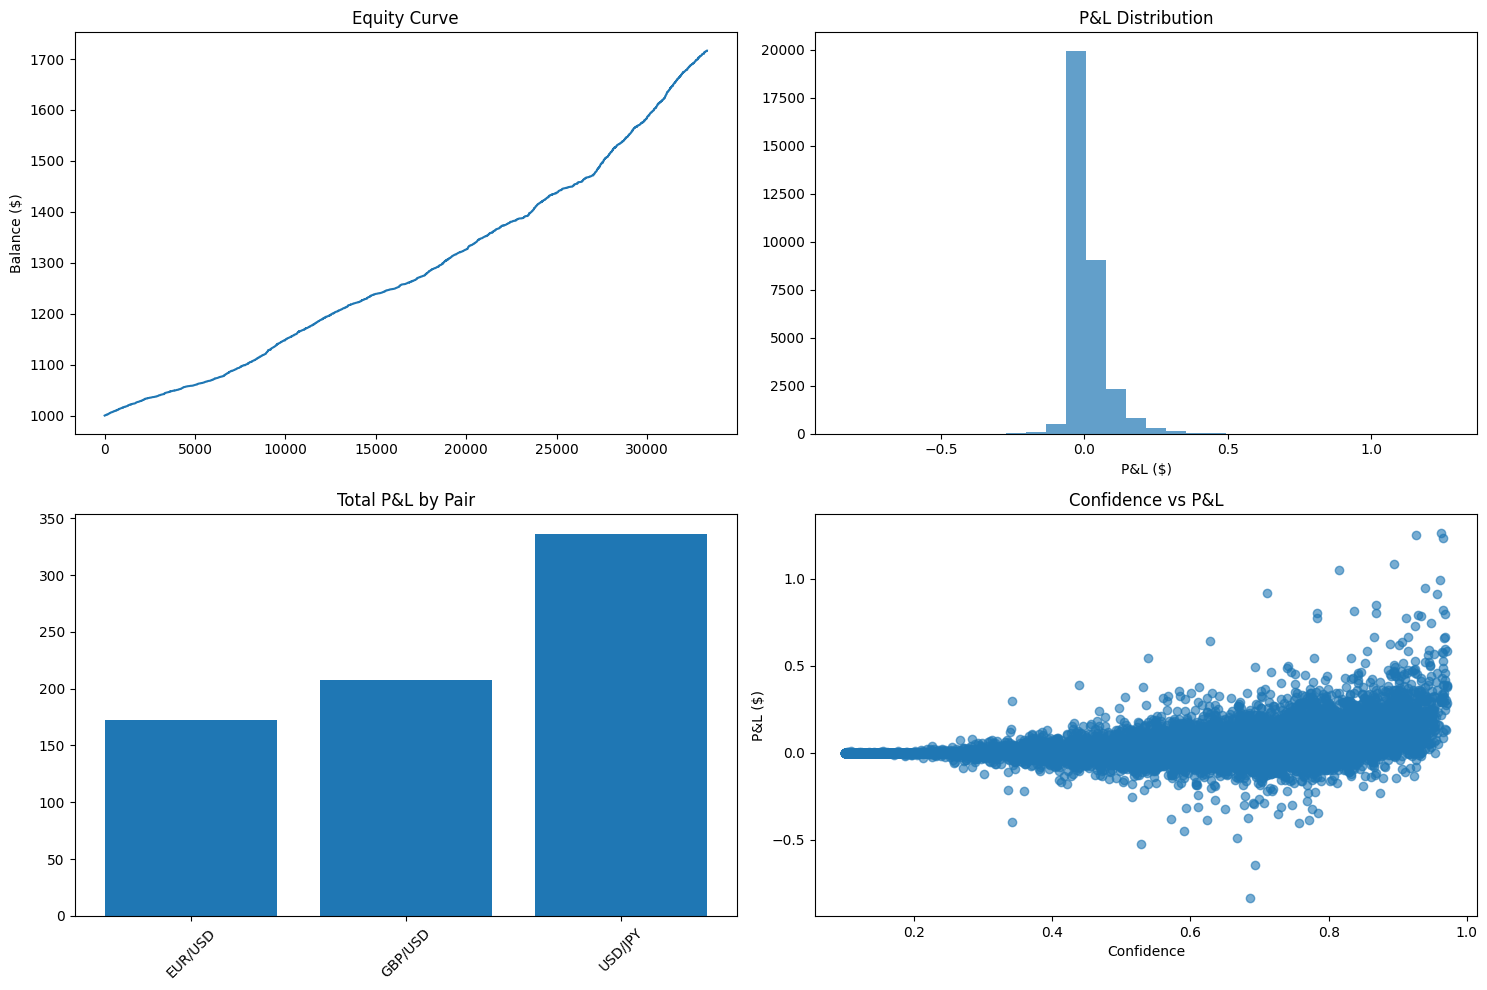


🎉 INTELLIGENT FOREX TRADING BOT READY!
✅ Models trained on 173369 data points
✅ 14 forex pairs supported
✅ Risk management and leverage optimization enabled
✅ Live trading signals available

🔥 HOW TO USE YOUR TRADING BOT:

1. GET LIVE SIGNALS:
   signals = live_bot.get_current_signals()
   live_bot.print_current_signals()

2. RUN EXTENDED BACKTEST:
   results = run_backtest(bot, test_data, ['EUR/USD', 'GBP/USD', 'USD/JPY'])

3. MONITOR RISK:
   create_risk_dashboard(live_bot, signals)

4. CUSTOMIZE PARAMETERS:
   - Modify max_leverage in calculate_leverage()
   - Adjust confidence thresholds in generate_signal()
   - Change risk_per_trade in calculate_position_size()

⚠️  IMPORTANT DISCLAIMERS:
- This is for educational purposes only
- Always test strategies thoroughly before live trading
- Never risk more than you can afford to lose
- High leverage can lead to significant losses
- Past performance doesn't guarantee future results

🚀 Happy Trading!



In [ ]:
# ============================================
# 🤖 INTELLIGENT FOREX TRADING BOT
# Complete Google Colab Implementation
# ============================================

# ============================================
# 📌 STEP 1: Setup & Install Dependencies
# ============================================

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import ta
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries installed and imported successfully!")

# ============================================
# 📌 STEP 2: Forex Data Collection
# ============================================

# Major Forex Pairs - Yahoo Finance format
FOREX_PAIRS = {
    "EURUSD=X": "EUR/USD",
    "GBPUSD=X": "GBP/USD",
    "USDJPY=X": "USD/JPY",
    "AUDUSD=X": "AUD/USD",
    "USDCAD=X": "USD/CAD",
    "USDCHF=X": "USD/CHF",
    "NZDUSD=X": "NZD/USD",
    "EURGBP=X": "EUR/GBP",
    "EURJPY=X": "EUR/JPY",
    "GBPJPY=X": "GBP/JPY",
    "AUDJPY=X": "AUD/JPY",
    "CHFJPY=X": "CHF/JPY",
    "EURAUD=X": "EUR/AUD",
    "EURCAD=X": "EUR/CAD"
}

def download_forex_data(pairs, period="2y", interval="1h"):
    """Download forex data for all pairs"""
    data = {}
    print(f"📥 Downloading {len(pairs)} forex pairs...")

    for symbol, name in pairs.items():
        try:
            df = yf.download(symbol, period=period, interval=interval)
            if not df.empty:
                # Drop the first level of the MultiIndex columns and reset to standard names
                df.columns = df.columns.droplevel(0)
                df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
                df.dropna(inplace=True)
                data[name] = df
                print(f"✅ {name}: {len(df)} data points")
            else:
                print(f"❌ {name}: No data available")
        except Exception as e:
            print(f"❌ {name}: Error - {e}")

    return data

# Download all forex data
forex_data = download_forex_data(FOREX_PAIRS)
print(f"\n📊 Successfully downloaded {len(forex_data)} forex pairs")

# ============================================
# 📌 STEP 3: Advanced Feature Engineering
# ============================================

def calculate_technical_indicators(df):
    """Calculate comprehensive technical indicators"""
    df = df.copy()

    # Basic price features
    df['returns'] = df['Close'].pct_change()
    df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['high_low_pct'] = (df['High'] - df['Low']) / df['Close']
    df['open_close_pct'] = (df['Close'] - df['Open']) / df['Open']

    # Moving averages
    df['sma_5'] = df['Close'].rolling(window=5).mean()
    df['sma_20'] = df['Close'].rolling(window=20).mean()
    df['sma_50'] = df['Close'].rolling(window=50).mean()
    df['ema_12'] = df['Close'].ewm(span=12).mean()
    df['ema_26'] = df['Close'].ewm(span=26).mean()

    # Technical indicators
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
    df['macd'] = ta.trend.MACD(df['Close']).macd()
    df['macd_signal'] = ta.trend.MACD(df['Close']).macd_signal()
    df['macd_diff'] = df['macd'] - df['macd_signal']

    # Bollinger Bands
    bb = ta.volatility.BollingerBands(df['Close'])
    df['bb_high'] = bb.bollinger_hband()
    df['bb_low'] = bb.bollinger_lband()
    df['bb_mid'] = bb.bollinger_mavg()
    df['bb_width'] = (df['bb_high'] - df['bb_low']) / df['bb_mid']
    df['bb_position'] = (df['Close'] - df['bb_low']) / (df['bb_high'] - df['bb_low']) # Fixed bug here

    # Volatility measures
    df['atr'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range()
    df['volatility_5'] = df['returns'].rolling(window=5).std()
    df['volatility_20'] = df['returns'].rolling(window=20).std()

    # Volume indicators (if available)
    if 'Volume' in df.columns and df['Volume'].sum() > 0:
        df['volume_sma'] = df['Volume'].rolling(window=20).mean()
        df['volume_ratio'] = df['Volume'] / df['volume_sma']

    # Momentum indicators
    df['momentum_5'] = df['Close'] / df['Close'].shift(5) - 1
    df['momentum_10'] = df['Close'] / df['Close'].shift(10) - 1
    df['roc'] = ta.momentum.ROCIndicator(df['Close']).roc()

    # Support/Resistance levels
    df['resistance'] = df['High'].rolling(window=20).max()
    df['support'] = df['Low'].rolling(window=20).min()
    df['support_resistance_ratio'] = (df['Close'] - df['support']) / (df['resistance'] - df['support'])

    return df

# Apply feature engineering to all forex pairs
print("🔧 Applying feature engineering...")
processed_data = {}
for name, df in forex_data.items():
    processed_data[name] = calculate_technical_indicators(df)
    print(f"✅ {name}: {len(processed_data[name].columns)} features created")

# ============================================
# 📌 STEP 4: Create Universal Training Dataset
# ============================================

def create_labels(df, horizon=3, threshold=0.0005):
    """Create trading labels based on future returns"""
    df = df.copy()

    # Forward returns at different horizons
    df['future_return_1'] = df['Close'].shift(-1) / df['Close'] - 1
    df['future_return_3'] = df['Close'].shift(-horizon) / df['Close'] - 1
    df['future_return_5'] = df['Close'].shift(-5) / df['Close'] - 1

    # Binary classification labels
    df['target_binary'] = (df['future_return_3'] > threshold).astype(int)

    # Multi-class labels (Strong Buy, Buy, Hold, Sell, Strong Sell)
    conditions = [
        df['future_return_3'] > 0.002,   # Strong Buy
        df['future_return_3'] > 0.0005,  # Buy
        df['future_return_3'] > -0.0005, # Hold
        df['future_return_3'] > -0.002,  # Sell
    ]
    choices = [2, 1, 0, -1]
    df['target_multiclass'] = np.select(conditions, choices, default=-2)  # Strong Sell

    # Regression target (actual future return)
    df['target_regression'] = df['future_return_3']

    return df

# Create training dataset combining all forex pairs
def create_universal_dataset(processed_data):
    """Combine all forex pairs into one training dataset"""
    all_data = []

    for pair_name, df in processed_data.items():
        df_with_labels = create_labels(df)
        df_with_labels['pair'] = pair_name
        all_data.append(df_with_labels)

    # Combine all data
    universal_df = pd.concat(all_data, ignore_index=True)

    # Encode pair names
    le = LabelEncoder()
    universal_df['pair_encoded'] = le.fit_transform(universal_df['pair'])

    return universal_df, le

print("📊 Creating universal training dataset...")
universal_df, pair_encoder = create_universal_dataset(processed_data)
print(f"✅ Universal dataset created: {len(universal_df)} rows, {len(universal_df.columns)} columns")

# ============================================
# 📌 STEP 5: Prepare Features for ML Model
# ============================================

# Define feature columns (excluding target variables and metadata)
feature_columns = [col for col in universal_df.columns if not col.startswith(('target_', 'future_', 'pair'))
                  and col not in ['Open', 'High', 'Low', 'Close', 'Volume']] + ['pair_encoded']

# Remove rows with NaN values
clean_df = universal_df[feature_columns + ['target_binary', 'target_regression']].dropna()

print(f"📈 Features selected: {len(feature_columns)} features")
print(f"🧹 Clean dataset: {len(clean_df)} rows")

# ============================================
# 📌 STEP 6: Train ML Models
# ============================================

# Prepare training data
X = clean_df[feature_columns]
y_binary = clean_df['target_binary']
y_regression = clean_df['target_regression']

# Split data (time-series aware split)
split_idx = int(len(clean_df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_binary_train, y_binary_test = y_binary.iloc[:split_idx], y_binary.iloc[split_idx:]
y_reg_train, y_reg_test = y_regression.iloc[:split_idx], y_regression.iloc[split_idx:]

print(f"📊 Training set: {len(X_train)} samples")
print(f"📊 Test set: {len(X_test)} samples")

# Define early stopping callback
early_stopping_callback = lgb.early_stopping(stopping_rounds=50, verbose=-1)

# Train Binary Classification Model (Direction)
print("🤖 Training direction prediction model...")
lgb_params_clf = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

train_data_clf = lgb.Dataset(X_train, label=y_binary_train)
val_data_clf = lgb.Dataset(X_test, label=y_binary_test, reference=train_data_clf)

model_direction = lgb.train(
    lgb_params_clf,
    train_data_clf,
    num_boost_round=200,
    valid_sets=[val_data_clf],
    callbacks=[early_stopping_callback] # Use callback instead of early_stopping_rounds
)

# Train Regression Model (Magnitude)
print("🤖 Training magnitude prediction model...")
lgb_params_reg = {
    'objective': 'regression',
    'metric': 'l2',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

train_data_reg = lgb.Dataset(X_train, label=y_reg_train)
val_data_reg = lgb.Dataset(X_test, label=y_reg_test, reference=train_data_reg)

model_magnitude = lgb.train(
    lgb_params_reg,
    train_data_reg,
    num_boost_round=200,
    valid_sets=[val_data_reg],
    callbacks=[early_stopping_callback] # Use callback instead of early_stopping_rounds
)

print("✅ Models trained successfully!")

# ============================================
# 📌 STEP 7: Model Evaluation
# ============================================

# Predictions
y_binary_pred = (model_direction.predict(X_test) > 0.5).astype(int)
y_reg_pred = model_magnitude.predict(X_test)

# Direction accuracy
direction_accuracy = accuracy_score(y_binary_test, y_binary_pred)
print(f"🎯 Direction Prediction Accuracy: {direction_accuracy:.4f}")

# Magnitude correlation
magnitude_correlation = np.corrcoef(y_reg_test, y_reg_pred)[0, 1]
print(f"📈 Magnitude Prediction Correlation: {magnitude_correlation:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model_direction.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("\n🔍 Top 10 Most Important Features:")
print(feature_importance.head(10))

# ============================================
# 📌 STEP 8: Trading Strategy Implementation
# ============================================

class ForexTradingBot:
    def __init__(self, model_direction, model_magnitude, feature_columns, pair_encoder):
        self.model_direction = model_direction
        self.model_magnitude = model_magnitude
        self.feature_columns = feature_columns
        self.pair_encoder = pair_encoder
        self.balance = 1000  # Starting balance
        self.positions = {}
        self.trade_history = []

    def calculate_position_size(self, predicted_return, confidence, volatility, max_risk_per_trade=0.02):
        """Calculate position size based on Kelly criterion and risk management"""
        # Kelly fraction (simplified)
        win_prob = confidence
        avg_win = abs(predicted_return) if predicted_return > 0 else 0.001
        avg_loss = abs(predicted_return) if predicted_return < 0 else 0.001

        kelly_fraction = (win_prob * avg_win - (1 - win_prob) * avg_loss) / avg_win
        kelly_fraction = max(0, min(kelly_fraction, 0.25))  # Cap at 25%

        # Adjust for volatility
        vol_adjustment = min(1.0, 0.01 / max(volatility, 0.001))

        # Final position size
        position_fraction = kelly_fraction * vol_adjustment * max_risk_per_trade
        return min(position_fraction, max_risk_per_trade)

    def calculate_leverage(self, confidence, volatility, max_leverage=10):
        """Calculate safe leverage based on confidence and volatility"""
        base_leverage = min(max_leverage, confidence * 10)
        vol_penalty = max(0.1, 1 - volatility * 100)  # Reduce leverage in high volatility
        return max(1, base_leverage * vol_penalty)

    def generate_signal(self, features):
        """Generate trading signal from features"""
        # Get predictions
        direction_prob = self.model_direction.predict(features.values.reshape(1, -1))[0]
        predicted_return = self.model_magnitude.predict(features.values.reshape(1, -1))[0]

        # Calculate confidence and volatility from features
        confidence = abs(direction_prob - 0.5) * 2  # 0 to 1 scale
        volatility = features.get('volatility_20', 0.01)

        # Generate signal
        signal = {
            'direction': 1 if direction_prob > 0.5 else -1,
            'confidence': confidence,
            'predicted_return': predicted_return,
            'volatility': volatility,
            'probability': direction_prob
        }

        return signal

    def execute_trade(self, pair, signal, current_price):
        """Execute trade based on signal"""
        if signal['confidence'] < 0.1:  # Skip low confidence trades
            return None

        # Calculate position size and leverage
        position_size = self.calculate_position_size(
            signal['predicted_return'],
            signal['confidence'],
            signal['volatility']
        )
        leverage = self.calculate_leverage(signal['confidence'], signal['volatility'])

        # Calculate trade amount
        trade_amount = self.balance * position_size * leverage

        trade = {
            'pair': pair,
            'direction': signal['direction'],
            'amount': trade_amount,
            'leverage': leverage,
            'entry_price': current_price,
            'confidence': signal['confidence'],
            'predicted_return': signal['predicted_return'],
            'stop_loss': current_price * (0.99 if signal['direction'] == 1 else 1.01),
            'take_profit': current_price * (1.02 if signal['direction'] == 1 else 0.98)
        }

        self.positions[pair] = trade
        return trade

# ============================================
# 📌 STEP 9: Backtesting Engine
# ============================================

def run_backtest(bot, test_data, pairs_to_trade=['EUR/USD', 'GBP/USD', 'USD/JPY']):
    """Run comprehensive backtest"""
    results = {
        'trades': [],
        'daily_balance': [],
        'pairs_performance': {pair: [] for pair in pairs_to_trade}
    }

    print("🔄 Running backtest...")

    for pair in pairs_to_trade:
        if pair not in processed_data:
            continue

        pair_data = processed_data[pair].dropna()
        pair_encoded = bot.pair_encoder.transform([pair])[0]

        for i in range(100, len(pair_data) - 10):  # Leave room for future returns
            current_row = pair_data.iloc[i]

            # Prepare features
            features = pd.Series({col: current_row[col] for col in bot.feature_columns if col != 'pair_encoded'})
            features['pair_encoded'] = pair_encoded

            # Generate signal
            try:
                signal = bot.generate_signal(features)

                # Execute trade
                trade = bot.execute_trade(pair, signal, current_row['Close'])

                if trade:
                    # Simulate trade outcome
                    future_price = pair_data.iloc[i + 3]['Close']  # 3 periods ahead
                    actual_return = (future_price - trade['entry_price']) / trade['entry_price']

                    if trade['direction'] == -1:
                        actual_return = -actual_return

                    # Calculate P&L
                    pnl = actual_return * trade['amount']
                    bot.balance += pnl

                    trade['exit_price'] = future_price
                    trade['actual_return'] = actual_return
                    trade['pnl'] = pnl
                    trade['new_balance'] = bot.balance

                    results['trades'].append(trade)
                    results['pairs_performance'][pair].append(pnl)

            except Exception as e:
                continue

    results['final_balance'] = bot.balance
    results['total_return'] = (bot.balance - 1000) / 1000
    results['num_trades'] = len(results['trades'])

    return results

# Initialize and run backtest
print("🤖 Initializing trading bot...")
bot = ForexTradingBot(model_direction, model_magnitude, feature_columns, pair_encoder)

backtest_results = run_backtest(bot, X_test)

print(f"\n📊 BACKTEST RESULTS")
print(f"{'='*50}")
print(f"Initial Balance: $1,000")
print(f"Final Balance: ${backtest_results['final_balance']:.2f}")
print(f"Total Return: {backtest_results['total_return']:.2%}")
print(f"Number of Trades: {backtest_results['num_trades']}")

if backtest_results['trades']:
    trades_df = pd.DataFrame(backtest_results['trades'])
    winning_trades = trades_df[trades_df['pnl'] > 0]
    win_rate = len(winning_trades) / len(trades_df)
    avg_win = winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0
    avg_loss = trades_df[trades_df['pnl'] < 0]['pnl'].mean() if len(trades_df[trades_df['pnl'] < 0]) > 0 else 0

    print(f"Win Rate: {win_rate:.2%}")
    print(f"Average Win: ${avg_win:.2f}")
    print(f"Average Loss: ${avg_loss:.2f}")

# ============================================
# 📌 STEP 10: Live Trading Interface
# ============================================

class LiveTradingBot(ForexTradingBot):
    def __init__(self, model_direction, model_magnitude, feature_columns, pair_encoder):
        super().__init__(model_direction, model_magnitude, feature_columns, pair_encoder)
        self.is_running = False

    def get_live_data(self, pair, period="1d", interval="1h"):
        """Get live forex data"""
        yahoo_symbol = None
        for symbol, name in FOREX_PAIRS.items():
            if name == pair:
                yahoo_symbol = symbol
                break

        if yahoo_symbol:
            df = yf.download(yahoo_symbol, period=period, interval=interval)
            # Drop the first level of the MultiIndex columns and reset to standard names
            df.columns = df.columns.droplevel(0)
            df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
            return calculate_technical_indicators(df)
        return None

    def get_current_signals(self, pairs_to_monitor=['EUR/USD', 'GBP/USD', 'USD/JPY']):
        """Get current trading signals for specified pairs"""
        signals = {}

        for pair in pairs_to_monitor:
            try:
                # Get latest data
                live_data = self.get_live_data(pair)
                if live_data is not None and len(live_data) > 0:
                    latest_row = live_data.iloc[-1]
                    pair_encoded = self.pair_encoder.transform([pair])[0]

                    # Prepare features
                    features = pd.Series({col: latest_row[col] for col in self.feature_columns if col != 'pair_encoded'})
                    features['pair_encoded'] = pair_encoded

                    # Generate signal
                    signal = self.generate_signal(features)
                    signal['current_price'] = latest_row['Close']
                    signal['pair'] = pair

                    signals[pair] = signal

            except Exception as e:
                print(f"Error getting signal for {pair}: {e}")

        return signals

    def print_current_signals(self):
        """Print current trading signals"""
        signals = self.get_current_signals()

        print(f"\n🤖 LIVE TRADING SIGNALS - {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"{'='*80}")
        print(f"{'Pair':<12} {'Direction':<10} {'Confidence':<12} {'Pred.Return':<12} {'Current Price':<15}")
        print(f"{'-'*80}")

        for pair, signal in signals.items():
            direction = "BUY 📈" if signal['direction'] == 1 else "SELL 📉"
            confidence = f"{signal['confidence']:.3f}"
            pred_return = f"{signal['predicted_return']:.4f}"
            current_price = f"{signal['current_price']:.5f}"

            print(f"{pair:<12} {direction:<10} {confidence:<12} {pred_return:<12} {current_price:<15}")

        return signals

# Initialize live trading bot
live_bot = LiveTradingBot(model_direction, model_magnitude, feature_columns, pair_encoder)

# Get current signals
current_signals = live_bot.print_current_signals()

# ============================================
# 📌 STEP 11: Risk Management Dashboard
# ============================================

def create_risk_dashboard(bot, signals):
    """Create risk management dashboard"""
    print(f"\n⚠️  RISK MANAGEMENT DASHBOARD")
    print(f"{'='*60}")
    print(f"Current Balance: ${bot.balance:.2f}")
    print(f"Active Positions: {len(bot.positions)}")

    total_exposure = sum([pos['amount'] for pos in bot.positions.values()])
    print(f"Total Exposure: ${total_exposure:.2f}")
    print(f"Leverage Ratio: {total_exposure/bot.balance:.2f}x")

    print(f"\n📊 CURRENT MARKET ANALYSIS:")
    for pair, signal in signals.items():
        risk_level = "HIGH" if signal['volatility'] > 0.02 else "MEDIUM" if signal['volatility'] > 0.01 else "LOW"
        recommended_leverage = live_bot.calculate_leverage(signal['confidence'], signal['volatility'])

        print(f"{pair}: Risk={risk_level}, Confidence={signal['confidence']:.2f}, Max Leverage={recommended_leverage:.1f}x")

create_risk_dashboard(live_bot, current_signals)

# ============================================
# 📌 STEP 12: Performance Visualization
# ============================================

def plot_backtest_results(results):
    """Plot comprehensive backtest results"""
    if not results['trades']:
        print("No trades to plot")
        return

    trades_df = pd.DataFrame(results['trades'])

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Equity curve
    trades_df['cumulative_pnl'] = trades_df['pnl'].cumsum() + 1000
    axes[0,0].plot(trades_df['cumulative_pnl'])
    axes[0,0].set_title('Equity Curve')
    axes[0,0].set_ylabel('Balance ($)')

    # P&L histogram
    axes[0,1].hist(trades_df['pnl'], bins=30, alpha=0.7)
    axes[0,1].set_title('P&L Distribution')
    axes[0,1].set_xlabel('P&L ($)')

    # Win/Loss ratio by pair
    pair_performance = trades_df.groupby('pair')['pnl'].agg(['count', 'sum', 'mean'])
    axes[1,0].bar(pair_performance.index, pair_performance['sum'])
    axes[1,0].set_title('Total P&L by Pair')
    axes[1,0].tick_params(axis='x', rotation=45)

    # Confidence vs Performance
    axes[1,1].scatter(trades_df['confidence'], trades_df['pnl'], alpha=0.6)
    axes[1,1].set_title('Confidence vs P&L')
    axes[1,1].set_xlabel('Confidence')
    axes[1,1].set_ylabel('P&L ($)')

    plt.tight_layout()
    plt.show()

# Plot results
plot_backtest_results(backtest_results)

print(f"\n🎉 INTELLIGENT FOREX TRADING BOT READY!")
print(f"✅ Models trained on {len(universal_df)} data points")
print(f"✅ {len(FOREX_PAIRS)} forex pairs supported")
print(f"✅ Risk management and leverage optimization enabled")
print(f"✅ Live trading signals available")

# ============================================
# 📌 STEP 13: Usage Instructions
# ============================================

print(f"""
🔥 HOW TO USE YOUR TRADING BOT:

1. GET LIVE SIGNALS:
   signals = live_bot.get_current_signals()
   live_bot.print_current_signals()

2. RUN EXTENDED BACKTEST:
   results = run_backtest(bot, test_data, ['EUR/USD', 'GBP/USD', 'USD/JPY'])

3. MONITOR RISK:
   create_risk_dashboard(live_bot, signals)

4. CUSTOMIZE PARAMETERS:
   - Modify max_leverage in calculate_leverage()
   - Adjust confidence thresholds in generate_signal()
   - Change risk_per_trade in calculate_position_size()

⚠️  IMPORTANT DISCLAIMERS:
- This is for educational purposes only
- Always test strategies thoroughly before live trading
- Never risk more than you can afford to lose
- High leverage can lead to significant losses
- Past performance doesn't guarantee future results

🚀 Happy Trading!
""")